# Imports

In [1]:
import os
from datetime import datetime

import geopandas as gpd
import movingpandas as mpd
import numpy as np
import torch
from shapely.geometry import Point
from sklearn.metrics import mean_absolute_error, mean_squared_error
from srai.datasets import PortoTaxiDataset
from srai.embedders import Hex2VecEmbedder
from srai.joiners import IntersectionJoiner
from srai.loaders import OSMPbfLoader
from srai.loaders.osm_loaders.filters import HEX2VEC_FILTER
from srai.neighbourhoods import H3Neighbourhood
from srai.regionalizers import H3Regionalizer
from srai.regionalizers import geocode_to_region_gdf
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [2]:
gpd.options.io_engine = "pyogrio"

# Enable loading Environment Variables

In [3]:
%load_ext dotenv

%dotenv

In [4]:
hf_token = os.getenv("HF_TOKEN")

# Data Loading

In [5]:
subset_size = 50_000
use_subset = True

gdf_porto_taxi_full_path = "porto_taxi.feather"
gdf_porto_taxi_subset_path = f"porto_taxi_subset_{subset_size}.feather"

In [6]:
if not use_subset:
    if not os.path.exists(gdf_porto_taxi_full_path):
        porto_taxi_dataset = PortoTaxiDataset()
        gdf_porto_taxi = porto_taxi_dataset.load(hf_token=hf_token)
        gdf_porto_taxi.to_feather(gdf_porto_taxi_full_path)
    else:
        gdf_porto_taxi = gpd.read_feather(gdf_porto_taxi_full_path)
else:
    if not os.path.exists(gdf_porto_taxi_subset_path):
        if not os.path.exists(gdf_porto_taxi_full_path):
            porto_taxi_dataset = PortoTaxiDataset()
            gdf_porto_taxi = porto_taxi_dataset.load(hf_token=hf_token)
            gdf_porto_taxi.to_feather(gdf_porto_taxi_full_path)
            gdf_porto_taxi = gdf_porto_taxi.head(subset_size)
            gdf_porto_taxi.to_feather(gdf_porto_taxi_subset_path)
        else:
            gdf_porto_taxi = gpd.read_feather(gdf_porto_taxi_full_path)
            gdf_porto_taxi = gdf_porto_taxi.head(subset_size)
            gdf_porto_taxi.to_feather(gdf_porto_taxi_subset_path)
    else:
        gdf_porto_taxi = gpd.read_feather(gdf_porto_taxi_subset_path)

In [7]:
gdf_porto_taxi.drop(
    [
        "taxi_id",
        "call_type",
        "origin_call",
        "origin_stand",
        "day_type",
        "travel_time_seconds",
    ],
    axis=1,
    inplace=True,
)

# Convert LineString to Point

In [8]:
exploded_rows = []

for idx, row in tqdm(gdf_porto_taxi.iterrows(), total=gdf_porto_taxi.shape[0]):
    start_timestamp = row.timestamp
    current_timestamp = start_timestamp
    for xy in row.geometry.coords:
        point = Point(xy)
        row_dict = row.to_dict()
        row_dict["geometry"] = point
        row_dict["timestamp"] = current_timestamp
        current_timestamp += 15
        exploded_rows.append(row_dict)

100%|██████████| 50000/50000 [00:19<00:00, 2541.41it/s]


In [9]:
gdf_porto_taxi_points = gpd.GeoDataFrame(exploded_rows, crs="EPSG:4326")

In [10]:
gdf_porto_taxi_points["timestamp"] = gdf_porto_taxi_points["timestamp"].apply(
    lambda x: datetime.fromtimestamp(x)
)

### Restricting to Porto Area

In [11]:
porto_area = geocode_to_region_gdf("Porto District, Portugal")

In [12]:
gdf_porto_taxi_points_inside_porto = gdf_porto_taxi_points.sjoin(porto_area)

In [13]:
gdf_merged = gdf_porto_taxi_points.merge(
    gdf_porto_taxi_points_inside_porto, how="left", indicator=True
)
df_porto_taxi_points_outside_porto = gdf_merged[gdf_merged["_merge"] == "left_only"]

In [14]:
trajectories_outside_porto = list(
    df_porto_taxi_points_outside_porto["trip_id"].unique()
)

In [15]:
gdf_porto_taxi_points = gdf_porto_taxi_points[
    ~gdf_porto_taxi_points["trip_id"].isin(trajectories_outside_porto)
]

# Trajectory Collection

In [16]:
trajectory_collection = mpd.TrajectoryCollection(
    data=gdf_porto_taxi_points, traj_id_col="trip_id", t="timestamp"
)

### Generalization

In [17]:
trajectory_collection = mpd.DouglasPeuckerGeneralizer(trajectory_collection).generalize(
    tolerance=0.0001
)

In [18]:
gdf_trajectory_point_collection = (
    trajectory_collection
    # .add_speed(overwrite=True)
    # .add_distance(overwrite=True)
    # .add_timedelta(overwrite=True)
    .to_point_gdf().sort_values(by=["trip_id", "timestamp"])
)

In [19]:
# scaler = MinMaxScaler()
# gdf_trajectory_point_collection[["speed", "distance"]] = scaler.fit_transform(
#     gdf_trajectory_point_collection[["speed", "distance"]]
# )

# Add Spatial Embedding

In [20]:
regionalizer = H3Regionalizer(resolution=9)
gdf_regions = regionalizer.transform(gdf_trajectory_point_collection)

In [21]:
loader = OSMPbfLoader()
gdf_features = loader.load(gdf_regions, HEX2VEC_FILTER)

C:\Virtual_Environments\venv_PNW_3.12\Lib\site-packages\srai\loaders\osm_loaders\osm_pbf_loader.py:128: FutureWarning: Use `convert_geometry_to_geodataframe` instead. Deprecated since 0.8.1 version.
  features_gdf = pbf_reader.get_features_gdf_from_geometry(
100%|###############################################| 333M/333M [00:00<?, ?B/s]
SHA256 hash of downloaded file: 33f31bcb64aa900c584a67d1827dff8d3cfcf2205766a9a965919ec0b23e121c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


Output()

Finished operation in 0:02:25

In [22]:
joiner = IntersectionJoiner()
gdf_joint = joiner.transform(gdf_regions, gdf_features)

In [23]:
neighbourhood = H3Neighbourhood(gdf_regions)

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"

embedder_hidden_sizes = [150, 100, 50, 10]
embedder = Hex2VecEmbedder(embedder_hidden_sizes)

df_embeddings = embedder.fit_transform(
    gdf_regions,
    gdf_features,
    gdf_joint,
    neighbourhood,
    trainer_kwargs={"max_epochs": 15, "accelerator": device},
    batch_size=100,
)

100%|██████████| 3963/3963 [00:00<00:00, 52366.69it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Virtual_Environments\venv_PNW_3.12\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
C:\Virtual_Environments\venv_PNW_3.12\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3080') tha

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [25]:
df_embeddings.rename(
    columns={
        0: "embedding_0",
        1: "embedding_1",
        2: "embedding_2",
        3: "embedding_3",
        4: "embedding_4",
        5: "embedding_5",
        6: "embedding_6",
        7: "embedding_7",
        8: "embedding_8",
        9: "embedding_9",
    },
    inplace=True,
)

In [26]:
gdf_joined = gpd.sjoin(gdf_trajectory_point_collection, gdf_regions, how="left")

In [27]:
gdf_joined.rename(columns={"index_right": "region_id"}, inplace=True)
gdf_joined.reset_index(inplace=True)

In [28]:
gdf_points_embeddings = gdf_joined.merge(df_embeddings, on="region_id", how="left")

# Preparing DataSet

In [29]:
class TrajectoryDataset(Dataset):
    def __init__(self, df, seq_length):
        self.sequences = []
        self.labels = []
        self.seq_length = seq_length
        self._create_sequences(df)

    def _create_sequences(self, df):
        for trajectory_id in df["trip_id"].unique():
            trajectory_data = df[df["trip_id"] == trajectory_id]
            for i in range(len(trajectory_data) - self.seq_length):
                sequence = trajectory_data.iloc[i : i + self.seq_length]
                travel_time = (
                    sequence["timestamp"].iloc[-1] - sequence["timestamp"].iloc[0]
                ).total_seconds()
                self.sequences.append(
                    sequence[
                        [
                            "embedding_0",
                            "embedding_1",
                            "embedding_2",
                            "embedding_3",
                            "embedding_4",
                            "embedding_5",
                            "embedding_6",
                            "embedding_7",
                            "embedding_8",
                            "embedding_9",
                        ]
                    ].values
                )
                self.labels.append(travel_time)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(
            self.labels[idx], dtype=torch.float32
        )

In [30]:
seq_length = 10
dataset = TrajectoryDataset(gdf_points_embeddings, seq_length)

In [31]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)

In [32]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [33]:
import torch.nn as nn


class TravelTimeLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(TravelTimeLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


input_size = 10
hidden_size = 50
num_layers = 2
output_size = 1

model = TravelTimeLSTM(input_size, hidden_size, num_layers, output_size)
model = model.to(device)

In [34]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 50

In [35]:
for epoch in range(num_epochs):
    model.train()
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)

        # Forward pass
        outputs = model(sequences)
        loss = criterion(outputs, labels.unsqueeze(1))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/50], Loss: 154117.0938
Epoch [2/50], Loss: 43984.4297
Epoch [3/50], Loss: 2914.9707
Epoch [4/50], Loss: 6387.0386
Epoch [5/50], Loss: 7571.8442
Epoch [6/50], Loss: 5382.1699
Epoch [7/50], Loss: 12154.4521
Epoch [8/50], Loss: 6082.2510
Epoch [9/50], Loss: 13583.5508
Epoch [10/50], Loss: 6770.0054
Epoch [11/50], Loss: 11089.3525
Epoch [12/50], Loss: 4391.8799
Epoch [13/50], Loss: 6069.0327
Epoch [14/50], Loss: 3167.4622
Epoch [15/50], Loss: 3669.2551
Epoch [16/50], Loss: 7183.3081
Epoch [17/50], Loss: 15122.7256
Epoch [18/50], Loss: 9237.8682
Epoch [19/50], Loss: 8792.7607
Epoch [20/50], Loss: 4781.7534
Epoch [21/50], Loss: 2564.9072
Epoch [22/50], Loss: 4882.2798
Epoch [23/50], Loss: 21962.6875
Epoch [24/50], Loss: 3060.1655
Epoch [25/50], Loss: 3548.7834
Epoch [26/50], Loss: 5388.2935
Epoch [27/50], Loss: 13729.9785
Epoch [28/50], Loss: 2855.7297
Epoch [29/50], Loss: 78585.1953
Epoch [30/50], Loss: 44957.8672
Epoch [31/50], Loss: 2404.8716
Epoch [32/50], Loss: 3977.9592
Epoch 

In [36]:
# Evaluating the model
model.eval()
test_loss = 0
with torch.no_grad():
    for sequences, labels in test_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = model(sequences)
        loss = criterion(outputs, labels.unsqueeze(1))
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 15326.1775


In [37]:
# Make predictions
predictions = []
actuals = []
with torch.no_grad():
    for sequences, labels in test_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = model(sequences)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(labels.cpu().numpy())

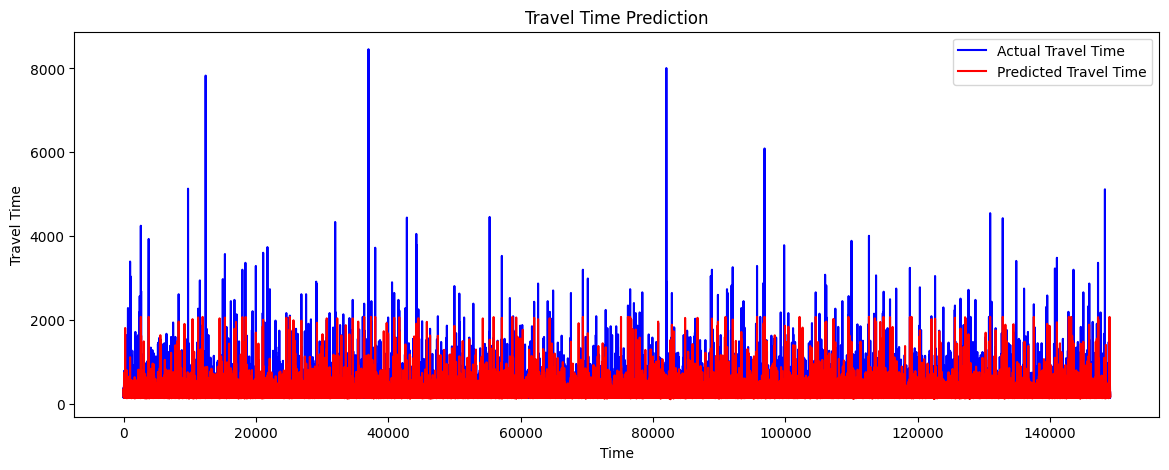

In [38]:
# Optionally, inverse transform the predictions if needed
# predictions = scaler.inverse_transform(predictions)

# Compare predicted travel time with actual travel time
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(actuals, color="blue", label="Actual Travel Time")
plt.plot(predictions, color="red", label="Predicted Travel Time")
plt.title("Travel Time Prediction")
plt.xlabel("Time")
plt.ylabel("Travel Time")
plt.legend()
plt.show()

In [39]:
mean_time_travelled = np.mean(actuals)
print(f"Mean average travelled time: {mean_time_travelled}")

mae = mean_absolute_error(actuals, predictions)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

mse = mean_squared_error(actuals, predictions)
print(f"Mean Squared Error (MSE): {mse:.4f}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean average travelled time: 247.67449951171875
Mean Absolute Error (MAE): 59.9861
Mean Squared Error (MSE): 15329.5273
Root Mean Squared Error (RMSE): 123.8125


In [43]:
np.min(actuals), np.max(actuals), np.mean(actuals), np.median(actuals)

(135.0, 8460.0, 247.6745, 210.0)

In [44]:
np.min(predictions), np.max(predictions), np.mean(predictions), np.median(predictions)

(102.68506, 2070.7375, 247.21028, 232.7645)